### Setting up working environment 

Please log in to your account and go to the following page: https://colab.research.google.com. Then upload this notebook.

For GPU support, go to "Edit" -> "Notebook Settings", and select "Hardware accelerator" as "GPU".

You will need to install pytorch by running the following cell:

In [0]:
!pip install torch torchvision

## Part 1

- implement the forward pass for Conv2D, MaxPool2D, Linear and BatchNorm2d


In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F

USE_GPU = False
dtype = torch.float32 

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

class Conv2d(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride=1,
                 padding=0,
                 bias=True):

        super(Conv2d, self).__init__()
        """
        An implementation of a convolutional layer.

        The input consists of N data points, each with C channels, height H and
        width W. We convolve each input with F different filters, where each filter
        spans all C channels and has height HH and width WW.

        Parameters:
        - w: Filter weights of shape (F, C, HH, WW)
        - b: Biases, of shape (F,)
        - kernel_size: Size of the convolving kernel
        - stride: The number of pixels between adjacent receptive fields in the
            horizontal and vertical directions.
        - padding: The number of pixels that will be used to zero-pad the input.
        """


        self.shape = (out_channels, in_channels, kernel_size, kernel_size)
        self.w = torch.randn(self.shape, device=device, dtype=dtype, requires_grad=True)
        self.b = torch.zeros(out_channels, dtype=dtype, device=device, requires_grad=True)
        self.stride = stride
        self.padding = padding
        self.bias = bias
        self.kernel_size = kernel_size
        

    def forward(self, x):
        """
        Input:
        - x: Input data of shape (N, C, H, W)
        Output:
        - out: Output data, of shape (N, F, H', W').
        """


        input_unfold = F.unfold(x, (self.kernel_size, self.kernel_size), padding=self.padding, stride=self.stride)
        out_unfold = input_unfold.transpose(1, 2).matmul(self.w.view(self.w.size(0), -1).t()).transpose(1, 2)
        H = int((x.shape[2]-self.kernel_size+2*self.padding)/self.stride+1)
        W = int((x.shape[3]-self.kernel_size+2*self.padding)/self.stride+1)
        if self.bias:
            out_unfold += self.b.view(-1,1)
        out = out_unfold.view((x.shape[0], self.shape[0], H, W))


        return out

In [0]:
class MaxPool2d(nn.Module):
    def __init__(self, kernel_size):
        super(MaxPool2d, self).__init__()
        """
        An implementation of a max-pooling layer.

        Parameters:
        - kernel_size: the size of the window to take a max over
        """

        self.kernel_size = kernel_size

    def forward(self, x):
        """
        Input:
        - x: Input data of shape (N, C, H, W)
        Output:
        - out: Output data, of shape (N, F, H', W').
        """


        H = int((x.shape[2]-self.kernel_size)/self.kernel_size)+1
        W = int((x.shape[3]-self.kernel_size)/self.kernel_size)+1
        input_unfold = F.unfold(x, (self.kernel_size, self.kernel_size), stride=self.kernel_size)
        unfold_reshape = input_unfold.view(x.shape[0], x.shape[1], self.kernel_size**2, H*W)
        pool = torch.max(unfold_reshape, dim = 2, keepdim=True)[0]
        out = pool.view(x.shape[0], x.shape[1], H, W)


        return out

In [0]:
class Linear(nn.Module):
    def __init__(self, in_channels, out_channels, bias=True):
        super(Linear, self).__init__()
        """
        An implementation of a Linear layer.

        Parameters:
        - weight: the learnable weights of the module of shape (in_channels, out_channels).
        - bias: the learnable bias of the module of shape (out_channels).
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.w = torch.randn((in_channels, out_channels), dtype = dtype, device = device, requires_grad=True)
        self.b = torch.randn((out_channels), dtype = dtype, device = device, requires_grad=True)
        self.bias = bias



    def forward(self, x):
        """
        Input:
        - x: Input data of shape (N, *, H) where * means any number of additional
        dimensions and H = in_channels
        Output:
        - out: Output data of shape (N, *, H') where * means any number of additional
        dimensions and H' = out_channels
        """


        inp = x. view(x.shape[0], x.shape[-1])
        out = inp.matmul(self.w)
        if self.bias:
            out += self.b


        return out

In [0]:
class BatchNorm2d(nn.Module):
    def __init__(self, num_features, eps=1e-05, momentum=0.1):
        super(BatchNorm2d, self).__init__()
        """
        An implementation of a Batch Normalization over a mini-batch of 2D inputs.

        The mean and standard-deviation are calculated per-dimension over the
        mini-batches and gamma and beta are learnable parameter vectors of
        size num_features.

        Parameters:
        - num_features: C from an expected input of size (N, C, H, W).
        - eps: a value added to the denominator for numerical stability. Default: 1e-5
        - momentum: momentum – the value used for the running_mean and running_var
        computation. Default: 0.1
        - gamma: the learnable weights of shape (num_features).
        - beta: the learnable bias of the module of shape (num_features).
        """

        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum
        self.gamma = torch.ones((num_features), dtype = dtype, device = device, requires_grad=True)
        self.beta = torch.zeros((num_features), dtype = dtype, device = device, requires_grad=True)
        self.save_mean = torch.zeros((num_features,1,1))
        self.save_std = torch.zeros((num_features,1,1))



    def forward(self, x, is_train = True):
        """
        During training this layer keeps running estimates of its computed mean and
        variance, which are then used for normalization during evaluation.
        Input:
        - x: Input data of shape (N, C, H, W)
        Output:
        - out: Output data of shape (N, C, H, W) (same shape as input)
        """


        shape = x.shape
        inp = x.view(shape[0], shape[1], shape[2]*shape[3])
        inp_trans = inp.transpose(0,1)
        inp_reshape = inp_trans.reshape(shape[1], 1, shape[0]*shape[2]*shape[3])
        if is_train:
            inp_mean = torch.mean(inp_reshape, 2, keepdim=True)
            inp_std = torch.std(inp_reshape, 2, keepdim=True)
            stad_inp = ((inp_reshape-inp_mean)/torch.sqrt(inp_std**2+self.eps))*self.gamma.view(-1,1,1)+self.beta.view(-1,1,1)
            self.save_mean = (1-self.momentum)*inp_mean+self.momentum*self.save_mean
            self.save_std = (1-self.momentum)*inp_std+self.momentum*self.save_std
            stad_inp_ = stad_inp.view(shape[1], shape[0], -1)
            x = stad_inp_.transpose(0,1)
            x = x.view(shape[0], shape[1], shape[2], shape[3])
        else:
            stad_inp = ((inp_reshape-self.save_mean)/torch.sqrt(self.save_std**2+self.eps))*self.gamma.view(-1,1,1)+self.beta.view(-1,1,1)
            stad_inp_ = stad_inp.view(shape[1], shape[0], -1)
            x = stad_inp_.transpose(0,1)
            x = x.view(shape[0], shape[1], shape[2], shape[3])

        return x

In [0]:
torch.manual_seed(1)
channel_size = 3
x = torch.randn((32, channel_size, 32, 64))
bat1 = BatchNorm2d(channel_size)
out = bat1(x)
model = torch.nn.BatchNorm2d(channel_size)
model2 = torch.nn.BatchNorm2d(channel_size)
est = model(x)
est2 = model2(x)
print((est - out).abs().max())
print((est - est2).abs().max())
print(torch.sqrt(sum((est-out).view(-1)**2)))

tensor(3.7670e-05, grad_fn=<MaxBackward1>)
tensor(0., grad_fn=<MaxBackward1>)
tensor(0.0034, grad_fn=<SqrtBackward>)


In [0]:
conv2 = Conv2d(channel_size,6,3, bias=False)
#model = torch.nn.Conv2d(3,6,3)
out = conv2(x)
est = F.conv2d(x, conv2.w)
print(torch.sqrt(sum((est-out).view(-1)**2)))

tensor(0.0003, grad_fn=<SqrtBackward>)


In [0]:
kernel_size = 2
max2 = MaxPool2d(kernel_size)
model = torch.nn.MaxPool2d(kernel_size, stride=kernel_size)
out = max2(x)
est = model(x)
print(torch.sqrt(sum((est-out).view(-1)**2)))

tensor(0.)


In [0]:
dim = 10
y = torch.randn((500,dim))
linear = Linear(dim, 64, bias=False)
out = linear(y)
est = F.linear(y, linear.w.t())
print(torch.sqrt(sum((est-out).view(-1)**2)))

tensor(0., grad_fn=<SqrtBackward>)


## Part 2

Train the network to achieve the best possible test set accuracy after a maximum of 10 epochs of training.


In [0]:
import torch
from torch.nn import Conv2d, MaxPool2d
import torch.nn as nn
import torch.nn.functional as F

Next, we define ResNet-18:

In [0]:
# define resnet building blocks

class ResidualBlock(nn.Module): 
    def __init__(self, inchannel, outchannel, stride=1): 
        
        super(ResidualBlock, self).__init__() 
        
        self.left = nn.Sequential(Conv2d(inchannel, outchannel, kernel_size=3, 
                                         stride=stride, padding=1, bias=False), 
                                  nn.BatchNorm2d(outchannel), 
                                  nn.ReLU(inplace=True), 
                                  Conv2d(outchannel, outchannel, kernel_size=3, 
                                         stride=1, padding=1, bias=False), 
                                  nn.BatchNorm2d(outchannel)) 
        
        self.shortcut = nn.Sequential() 
        
        #make sure the size of the shortcut is the same as the left
        if stride != 1 or inchannel != outchannel: 
            
            self.shortcut = nn.Sequential(Conv2d(inchannel, outchannel, 
                                                 kernel_size=1, stride=stride, 
                                                 padding = 0, bias=False), 
                                          nn.BatchNorm2d(outchannel) ) 
            
    def forward(self, x): 
        
        out = self.left(x) 
        
        out += self.shortcut(x) 
        
        out = F.relu(out) 
        
        return out


    
    # define resnet

class ResNet(nn.Module):
    
    def __init__(self, ResidualBlock, num_classes = 10):
        
        super(ResNet, self).__init__()
        
        self.inchannel = 64
        self.conv1 = nn.Sequential(Conv2d(3, 64, kernel_size = 3, stride = 1,
                                            padding = 1, bias = False), 
                                  nn.BatchNorm2d(64), 
                                  nn.ReLU())
        
        self.layer1 = self.make_layer(ResidualBlock, 64, 2, stride = 1)
        self.layer2 = self.make_layer(ResidualBlock, 128, 2, stride = 2)
        self.layer3 = self.make_layer(ResidualBlock, 256, 2, stride = 2)
        self.layer4 = self.make_layer(ResidualBlock, 512, 2, stride = 2)
        self.maxpool = MaxPool2d(4)
        self.fc = nn.Linear(512, num_classes)
        
    
    def make_layer(self, block, channels, num_blocks, stride):
        
        strides = [stride] + [1] * (num_blocks - 1)
        
        layers = []
        
        for stride in strides:
            
            layers.append(block(self.inchannel, channels, stride))
            
            self.inchannel = channels
            
        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        
        x = self.conv1(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.maxpool(x)
        
        x = x.view(x.size(0), -1)
        
        x = self.fc(x)
        
        return x
    
    
def ResNet18():
    return ResNet(ResidualBlock)

### Loading dataset
We will import images from the [torchvision.datasets](https://pytorch.org/docs/stable/torchvision/datasets.html) library <br>
First, we need to define the alterations (transforms) we want to perform to our images - given that transformations are applied when importing the data. <br>
Define the following transforms using the torchvision.datasets library -- you can read the transforms documentation [here](https://pytorch.org/docs/stable/torchvision/transforms.html): <br>
1. Convert images to tensor
2. Normalize mean and std of images with values:mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010]

In [0]:
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset

import numpy as np

import torchvision.transforms as T

NUM_TRAIN = 49000

transform = T.Compose([
                T.ToTensor(),
                T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
            ])



Now load the dataset using the transform you defined above, with batch_size = 64<br>
You can check the documentation [here](https://pytorch.org/docs/stable/torchvision/datasets.html)
Then create data loaders (using DataLoader from torch.utils.data) for the training and test set

In [0]:


data_dir = './data'

cifar10_train = dset.CIFAR10(data_dir, train=True, download=True,
                             transform=transform)
loader_train = DataLoader(cifar10_train, batch_size=64, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

cifar10_val = dset.CIFAR10(data_dir, train=True, download=True,
                           transform=transform)
loader_val = DataLoader(cifar10_val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))

cifar10_test = dset.CIFAR10(data_dir, train=False, download=True, 
                            transform=transform)
loader_test = DataLoader(cifar10_test, batch_size=64)




0it [00:00, ?it/s]

170500096it [00:03, 43150930.28it/s]                               


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified


In [0]:
USE_GPU = True
dtype = torch.float32 

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
    

print_every = 100
def check_accuracy(loader, model):
    # function for test accuracy on validation and test set
    
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

        

def train_part(model, optimizer, epochs=1):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        print(len(loader_train))
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            loss.backward()

            # Update the parameters of the model using the gradients
            optimizer.step()

            if t % print_every == 0:
                print('Epoch: %d, Iteration %d, loss = %.4f' % (e, t, loss.item()))
                check_accuracy(loader_val, model)
                print()

In [0]:

model = ResNet18()

optimizer = optim.Adam(model.parameters())


# define and train the network


train_part(model, optimizer, epochs = 10)


# report test set accuracy

check_accuracy(loader_test, model)


# save the model
torch.save(model.state_dict(), 'model.pt')

766
Epoch: 0, Iteration 0, loss = 3.3065
Checking accuracy on validation set
Got 119 / 1000 correct (11.90)

Epoch: 0, Iteration 100, loss = 1.8319
Checking accuracy on validation set
Got 387 / 1000 correct (38.70)

Epoch: 0, Iteration 200, loss = 1.3772
Checking accuracy on validation set
Got 467 / 1000 correct (46.70)

Epoch: 0, Iteration 300, loss = 1.6720
Checking accuracy on validation set
Got 517 / 1000 correct (51.70)

Epoch: 0, Iteration 400, loss = 1.1562
Checking accuracy on validation set
Got 435 / 1000 correct (43.50)

Epoch: 0, Iteration 500, loss = 1.1527
Checking accuracy on validation set
Got 549 / 1000 correct (54.90)

Epoch: 0, Iteration 600, loss = 1.1164
Checking accuracy on validation set
Got 624 / 1000 correct (62.40)

Epoch: 0, Iteration 700, loss = 1.3712
Checking accuracy on validation set
Got 570 / 1000 correct (57.00)

766
Epoch: 1, Iteration 0, loss = 1.0071
Checking accuracy on validation set
Got 631 / 1000 correct (63.10)

Epoch: 1, Iteration 100, loss = 1

## Part 3

The code provided below will allow you to visualise the feature maps computed by different layers of your network.


<Figure size 432x288 with 0 Axes>

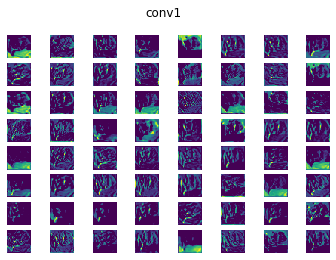

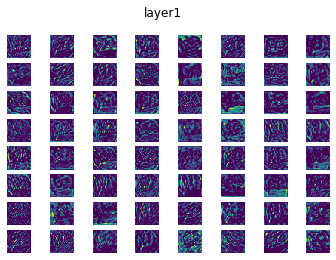

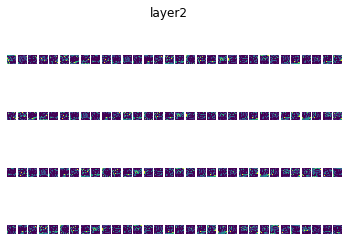

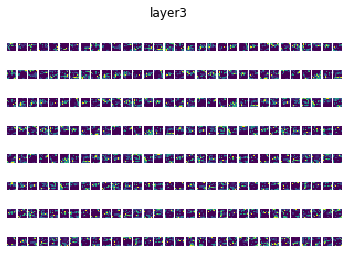

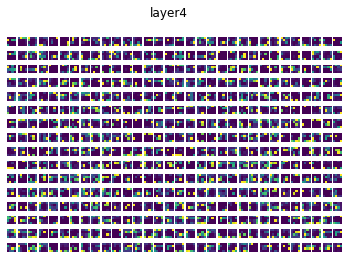

In [0]:
#!pip install matplotlib


import matplotlib.pyplot as plt

plt.tight_layout()


activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

vis_labels = ['conv1', 'layer1', 'layer2', 'layer3', 'layer4']

for l in vis_labels:

    getattr(model, l).register_forward_hook(get_activation(l))
    
    
data, _ = cifar10_test[0]
data = data.unsqueeze_(0).to(device = device, dtype = dtype)

output = model(data)



for idx, l in enumerate(vis_labels):

    act = activation[l].squeeze()

    if idx < 2:
        ncols = 8
    else:
        ncols = 32
        
    nrows = act.size(0) // ncols
    
    fig, axarr = plt.subplots(nrows, ncols)
    fig.suptitle(l)


    for i in range(nrows):
        for j in range(ncols):
            axarr[i, j].imshow(act[i * nrows + j].cpu())
            axarr[i, j].axis('off')